# <center>Image Hashing using PCA</center>

Hashing is most commonly used to implement hash tables and for data encryption. A hash table 
stores key/value pairs in the form of a list, while the hash function maps the elements of the dataset 
via a key and generates hash values. A real-world recognition system has to cope with several 
unseen individuals and determine whether a given face image is registered or not, and thus, certain 
elements in databases can be found much faster-using hashing functions and classification 
methods

### AIM:
Implement a basic hashing model from scratch that hashes the images

### PROCEDURE
- Importing Libraries.
- Reading the dataset.
- Resize the image to a suitable size, followed by grayscale conversion of the image and Plotting them.
- Then mean normalize the image to obtain a binary image, whose sum can be used as a hash value.
- Using the hash model, encode all the images present inside the directory.
- Search for images similar to the query image.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read Dataset

In [2]:
data_path = '../week16/mnist_test/mnist_test.csv'
df = pd.read_csv(data_path)
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.shape

(10000, 785)

In [4]:
data = df.values
X, y = data[:,1:], data[:,0]

In [5]:
X.shape, y.shape

((10000, 784), (10000,))

## Plot some images from dataset

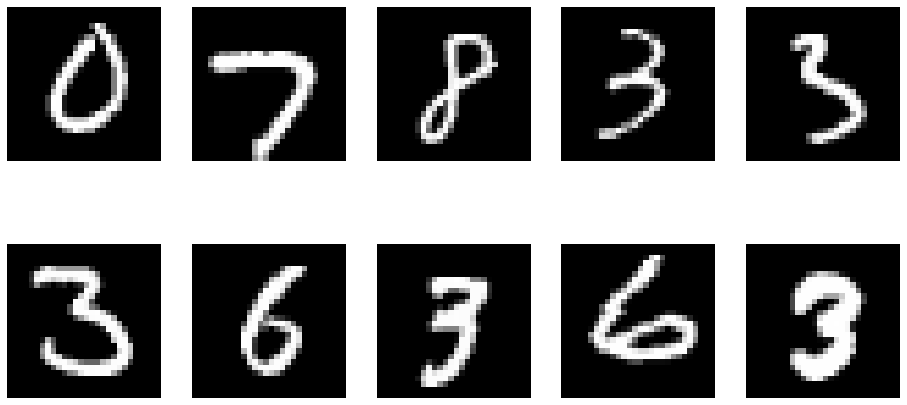

In [6]:
rand_idx = np.random.choice(X.shape[0], 10)

fig, ax = plt.subplots(2,5, figsize=(16,8))
c = 0
for i in range(2):
    for j in range(5):
        img = X[rand_idx[c],:]
        img_arr = np.uint8(img.reshape(28,28))
        ax[i,j].imshow(img_arr, cmap='gray')
        ax[i,j].set_axis_off()
        c += 1
plt.show()

# Image Vectorization and PCA

In [7]:
# Vectorize the images and converting to unit vectors
X_vec = []
for i in range(X.shape[0]):
    img_vec = X[i]
    img_vec_norm = img_vec/ np.linalg.norm(img_vec)
    X_vec.append(img_vec_norm)
X_vec = np.array(X_vec)

In [8]:
X_vec.shape

(10000, 784)

In [9]:
## Split dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.5, stratify=y, random_state=23) #sets for hashing

X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X, y, test_size=0.5, stratify=y, random_state=23) #sets for plotting

In [10]:
X_train.shape, X_test.shape

((5000, 784), (5000, 784))

In [11]:
y_train

array([3, 4, 2, ..., 1, 6, 5])

In [12]:
y_train_org

array([3, 4, 2, ..., 1, 6, 5])

In [13]:
# Dimensionility Reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.fit_transform(X_test)

In [14]:
X_train_transformed.shape, X_test_transformed.shape

((5000, 40), (5000, 40))

In [15]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([490, 568, 516, 505, 491, 446, 479, 514, 487, 504]))

In [16]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([490, 567, 516, 505, 491, 446, 479, 514, 487, 505]))

# Local Sensitive Hashing - Random Projections

In [17]:
## Function for creating random unit vectors in the space
def genRandomHashVectors(m, length):
    hash_vector = []
    for i in range(m):
        v = np.random.uniform(-1,1,length)
        vcap = v/np.linalg.norm(v)
        hash_vector.append(vcap)
    return np.array(hash_vector)

In [18]:
def localSensitiveHashing(hash_vector, data):
    hash_code = []
    for i in range(hash_vector.shape[0]):
        if np.dot(data, hash_vector[i]) >= 0:
            hash_code.append('1')
        else:
            hash_code.append('0')
    return ''.join(hash_code)

In [19]:
hash_vector = genRandomHashVectors(15, X_train_transformed.shape[1])

In [20]:
hash_vector.shape

(15, 40)

In [21]:
localSensitiveHashing(hash_vector, X_test_transformed[0])

'110000011001011'

# Hashing with Hierarchical Structures

In [43]:
## class for defining a Node of a Tree
class Node:
    def __init__(self) -> None:
        self.m_NodeIndex = -1
        self.m_NodeDepth = -1
        self.m_ParentIndex = -1
        self.m_LeftChildIndex = -1
        self.m_RightChildIndex = -1
        self.m_IsDecisionNode = None
        self.m_Dim = None
        self.m_Value = None
    
    def setNode(self, nodeIndex, nodeDepth, parentIndex):
        self.m_NodeIndex = nodeIndex
        self.m_NodeDepth = nodeDepth
        self.m_ParentIndex = parentIndex

In [52]:
## class for defining the Hash Tree architecture
class HashTree:
    def __init__(self, depth, path) -> None:
        self.m_Depth = depth
        self.m_CurrentNodeNum = 0
        self.m_NodeArray = [Node() for i in range(2**(depth+1)-1)]
        self.m_Path = path
    
    def splitDataFile(self, node_obj, dataLeft, dataRight):
        filename1 = self.m_Path+"/"+"d_"+str(node_obj.m_LeftChildIndex)+".csv"
        filename2 = self.m_Path+"/"+"d_"+str(node_obj.m_RightChildIndex)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, dataLeft, delimiter=',')
        np.savetxt(filename2, dataRight, delimiter=',')

    def segData(self, data, j, theta):
        dataLeft, dataRight = [], []
        for row in data:
            if row[j] >= theta:
                dataRight.append(row)
            else:
                dataLeft.append(row)
        return np.array(dataLeft), np.array(dataRight)

    def printNodeData(self, node):
        print("Node Index: ", node.m_NodeIndex)
        print("Node Depth: ", node.m_NodeDepth)
        print("Dimension: ", node.m_Dim)
        print("Value: ", node.m_Value)
        if node.m_IsDecisionNode == False:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")

    def fit(self, Data):
        filename = self.m_Path+"/"+"d_0.csv"
        data_df = pd.DataFrame(Data)
        data_df.to_csv(filename, header=False, index=False)
        self.m_NodeArray[0].setNode(nodeIndex=0,nodeDepth=0,parentIndex=-1)  ## create root node      
        self.m_CurrentNodeNum += 1
        
        for nodeCount in range(len(self.m_NodeArray)):

            if (self.m_NodeArray[nodeCount].m_NodeIndex == nodeCount and
                self.m_NodeArray[nodeCount].m_NodeDepth >= 0):

                filename = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndex)+".csv"
                if os.path.exists(filename):
                    data = np.genfromtxt(filename, delimiter=',')
                else:
                    print("File doesn't exists: {}".format(filename))

                if self.m_NodeArray[nodeCount].m_NodeDepth != self.m_Depth:
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = True

                    self.m_NodeArray[nodeCount].m_Dim = np.argmax(np.var(data, axis=0)) 
                    self.m_NodeArray[nodeCount].m_Value = np.median(data[:,self.m_NodeArray[nodeCount].m_Dim])
                    dataLeft, dataRight = self.segData(data, self.m_NodeArray[nodeCount].m_Dim, self.m_NodeArray[nodeCount].m_Value)
                    
                    lci = self.m_CurrentNodeNum 
                    rci = self.m_CurrentNodeNum + 1

                    self.m_NodeArray[nodeCount].m_LeftChildIndex = lci
                    self.m_NodeArray[nodeCount].m_RightChildIndex = rci

                    self.m_NodeArray[lci].setNode(lci, self.m_NodeArray[nodeCount].m_NodeDepth+1, self.m_NodeArray[nodeCount].m_NodeIndex)
                    self.m_NodeArray[rci].setNode(rci, self.m_NodeArray[nodeCount].m_NodeDepth+1, self.m_NodeArray[nodeCount].m_NodeIndex)
                    self.splitDataFile(self.m_NodeArray[nodeCount], dataLeft, dataRight)
                    self.m_CurrentNodeNum += 2

                else:
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = False
                self.printNodeData(self.m_NodeArray[nodeCount])
            else:
                print('Hash Tree is Built!!!!')
                break

    def getHashCode(self, data):
        hash_code = []
        nodeCount = 0
        while nodeCount < len(self.m_NodeArray):
            if self.m_NodeArray[nodeCount].m_IsDecisionNode == True:
                if data[self.m_NodeArray[nodeCount].m_Dim] >= self.m_NodeArray[nodeCount].m_Value:
                    hash_code.append('0')
                    nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndex
                else:
                    hash_code.append('1')
                    nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndex
            else:
                break
        return ''.join(hash_code)

In [63]:
path = "node_files/"
if not os.path.exists(path):
    os.mkdir(path=path)
hash_tree = HashTree(depth=3, path=path)
hash_tree.fit(Data=X_train)

Node Index:  0
Node Depth:  0
Dimension:  378
Value:  0.029760269353697015
This is a Decision Node!
Node Index:  1
Node Depth:  1
Dimension:  408
Value:  0.060038001684824066
This is a Decision Node!
Node Index:  2
Node Depth:  1
Dimension:  462
Value:  0.06363699664740649
This is a Decision Node!
Node Index:  3
Node Depth:  2
Dimension:  410
Value:  0.020165507667812846
This is a Decision Node!
Node Index:  4
Node Depth:  2
Dimension:  269
Value:  0.04496947406612861
This is a Decision Node!
Node Index:  5
Node Depth:  2
Dimension:  464
Value:  0.01643765042008489
This is a Decision Node!
Node Index:  6
Node Depth:  2
Dimension:  322
Value:  0.055281690896082814
This is a Decision Node!
Node Index:  7
Node Depth:  3
Dimension:  None
Value:  None
This is a Leaf Node!
Node Index:  8
Node Depth:  3
Dimension:  None
Value:  None
This is a Leaf Node!
Node Index:  9
Node Depth:  3
Dimension:  None
Value:  None
This is a Leaf Node!
Node Index:  10
Node Depth:  3
Dimension:  None
Value:  None

In [64]:
hash_tree.getHashCode(X_test[0])

'001'

In [65]:
image_dict = {}
for i in range(X_train.shape[0]):
    hash_code = hash_tree.getHashCode(X_train[i])
    if hash_code not in image_dict.keys():
        image_dict[hash_code] = [i]
    else:
        image_dict[hash_code].append(i)

In [66]:
image_dict.keys()

dict_keys(['011', '110', '101', '000', '010', '100', '111', '001'])

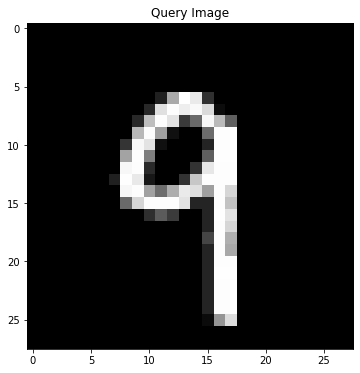

In [77]:
query_img = X_test_transformed[10]
query_img_plt = X_test_org[10]
plt.figure(figsize=(7,6))
plt.title('Query Image')
img = np.uint8(query_img_plt.reshape(28,28))
plt.imshow(img, cmap='gray')
plt.show()

In [78]:
def filter_searches(query_img, image_dict, k=5):
    query_hash_code = hash_tree.getHashCode(query_img)
    if query_hash_code in image_dict.keys():
        n_similar_arr = np.array(image_dict[query_hash_code])
        # print(n_similar_arr)
        if len(n_similar_arr) < k:
            print('Found just {} similar images'.format(len(n_similar_arr)))
            k = len(n_similar_arr)
        dist_ls = []
        for i in n_similar_arr:
            img = X_train[i]
            dist = np.linalg.norm(img - query_img)
            dist_ls.append(dist)
        dist_ls_sorted_ids = np.argsort(dist_ls)
        n_similar_sorted = n_similar_arr[dist_ls_sorted_ids]
        return n_similar_sorted[:k]
    else:
        print("No similar image found in database!!")
        return None    

In [79]:
ids = filter_searches(query_img=query_img_plt, image_dict=image_dict)
print(ids)

[4869  440 4572 1686 3571]


In [80]:
def plot_top_search(ids):
    k = len(ids)
    fig,ax = plt.subplots(1,k,figsize=(20,7))
    c=0
    for i in ids:
        img = X_train_org[i]
        img = np.uint8(img.reshape(28,28))
        ax[c].imshow(img, cmap='gray')
        ax[c].set_axis_off()
        ax[c].set_title('Result {}'.format(i))
        c += 1
    plt.show()

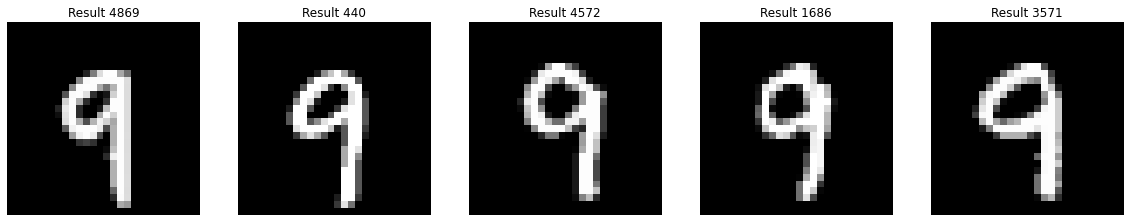

In [81]:
plot_top_search(ids)